# Reproduction of Tutorial Example using Lifelines Library

## General Steps to Conduct Survival Analysis
1. Load and preprocess the data
2. Estimate the survival function using Kaplan-Meier estimator
3. Plot the survival curve
4. Perform statistical comparisons using log-rank test (if applicable) 
5. Fit various parametric survival models to estimate cumulative hazards (e.g., Weibull, Exponential, Log-Normal, Log-Logistic, etc.)
6. Compare the models to select the best model
7. Fit Cox's proportional hazard model
8.  Check the proportional hazard assumption
9.  Predict survival function for new data
10. Evaluate the model predictive performance
11. Interpret the results
12. Conclusion

In [2]:
# Install lifelines
# !pip install lifelines

In [3]:
# Import libraries
import lifelines
print(lifelines.__version__)  # Should print the installed version


0.30.0


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys # for sys.path.append to work

## 1. Load and Preprocess the Data

Instructions for Analyzing Political Leader Lifetimes
1.	Definition: A political leader is an individual who controls the ruling regime, including elected presidents, unelected dictators, and monarchs.

2.	Lifetime Events:
- Birth Event: The start of the individual’s tenure.
- Death Event: Voluntary retirement from office.

3.	Censoring Criteria:
- The leader is still in office when the dataset was compiled (2008).
- The leader dies while in power (including assassinations).

In [5]:
from lifelines.datasets import load_dd

In [6]:
# Load the dataset 
data = load_dd() 
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


## 2. Estimate the survival function using Kaplan-Meier estimator

In [7]:
from lifelines import KaplanMeierFitter # for Kaplan Meier estimator

In [8]:
kmf = KaplanMeierFitter() # instantiate the class to create an object 

Fit the Kaplan-Meier estimator to the data to estimate the survival function. 


In [9]:
T = data["duration"]     ## time to event
E = data["observed"]      ## event occurred or censored 

kmf.fit(T, event_observed=E) 

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1808 total observations, 340 right-censored observations>

Visualize the survival curve using the Kaplan-Meier estimator. 

In [10]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Survival function of political regimes')

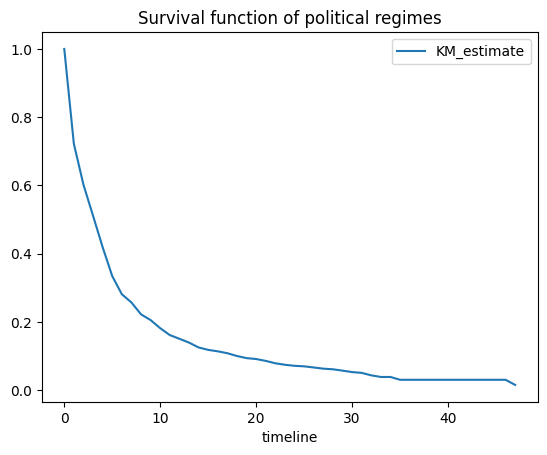

In [11]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes') 

The y-axis represents the probability a leader is still around after t years, and the x-axis represents the number of years a leader has been in power.

Add the confidence intervals to the plot to show the uncertainty in the survival estimates.

<Axes: xlabel='timeline'>

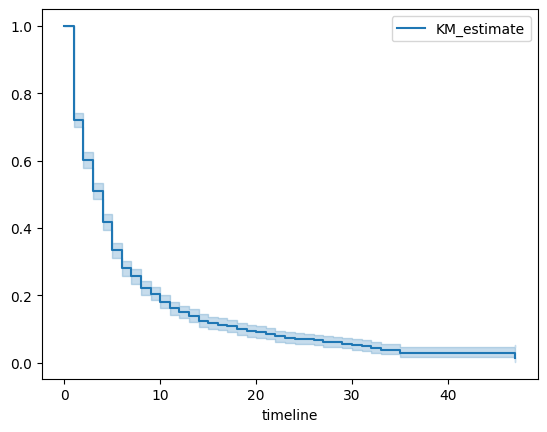

In [12]:
kmf.plot_survival_function()

In [13]:
# Median time in office
median = kmf.median_survival_time_
print(f"The median time in office is {median} years.")

The median time in office is 4.0 years.


Get the confidence intervals of the median. 


In [14]:
from lifelines.utils import median_survival_times 

In [15]:
median_ci = median_survival_times(kmf.confidence_interval_) 
print(median_ci)

     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     3.0                     4.0


## 3. Plot the survival curve

Text(0.5, 1.0, 'Lifespans of different global regimes')

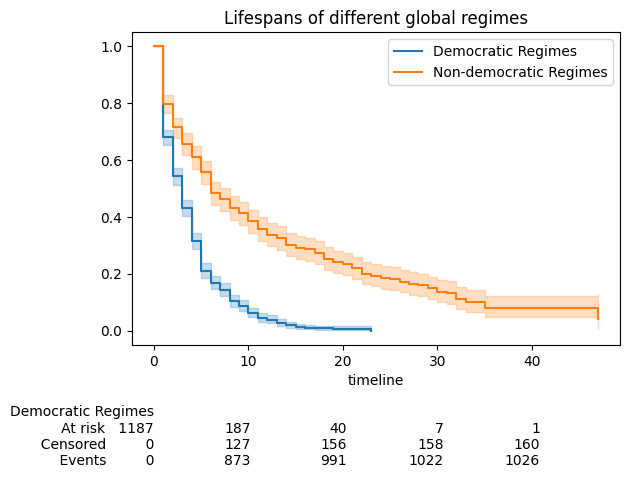

In [16]:
ax = plt.subplot(111) # To put the legend outside the plot 

dem = (data["democracy"] == "Democracy") # Data boolean of democracies 

kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes") 
kmf.plot_survival_function(ax=ax, at_risk_counts=True)  

kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot_survival_function(ax=ax, at_risk_counts=False)

plt.tight_layout()
plt.title("Lifespans of different global regimes")

## 4. Perform statistical comparisons using log-rank test

In [17]:
from lifelines.statistics import logrank_test 

In [18]:
# Test at the 5% significance level 
results = logrank_test(T[dem], T[~dem], 
                       E[dem], E[~dem], 
                       alpha=.95)  

In [19]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         260.47 <0.005    192.23

## 5. Fit various parametric survival models to estimate cumulative hazards (Weibull)

In [20]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons 

In [31]:
data_1 = load_waltons()

T_1 = data_1['T']  # life time of the subjects 
E_1 = data_1['E']  # censorship: 1 if death observed, 0 else 

print(E_1.value_counts())

E
1    156
0      7
Name: count, dtype: int64


In [32]:
wf = WeibullFitter().fit(T_1, E_1) # Fitting Weibull model 

In [33]:
wf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 163 total observations, 7 right-censored observations>
   number of observations = 163
number of events observed = 156
           log-likelihood = -672.06
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 55.73      1.33           53.13           58.33
rho_     3.45      0.24            2.97            3.93

         cmp to     z      p  -log2(p)
lambda_    1.00 41.26 <0.005       inf
rho_       1.00 10.07 <0.005     76.83
---
AIC = 1348.12

Text(0.5, 1.0, 'Cumulative hazard function of Weibull distribution')

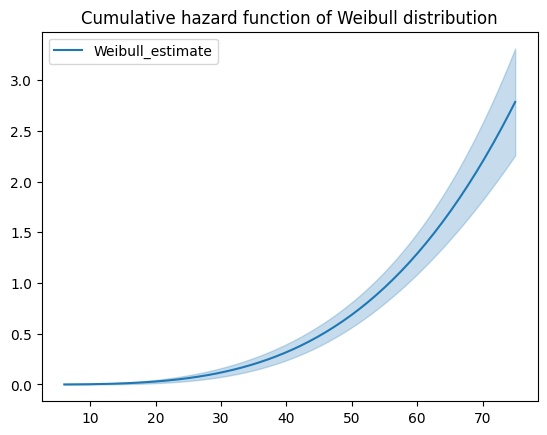

In [26]:
ax_weibull = wf.plot_cumulative_hazard()
ax_weibull.set_title('Cumulative hazard function of Weibull distribution') 

### Other parametric models: Exponential, Log-Logistic, Log-Normal and Splines 

Lifelines offers several parametric models for survival analysis. The choice of model typically depends on prior knowledge of duration distributions or model fit metrics. Below are the built-in parametric models and the Nelson-Aalen non-parametric model applied to the same data.

In [27]:
from lifelines import (WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, NelsonAalenFitter, PiecewiseExponentialFitter,
                       GeneralizedGammaFitter, SplineFitter)

In [28]:
from lifelines.datasets import load_waltons

<Axes: >

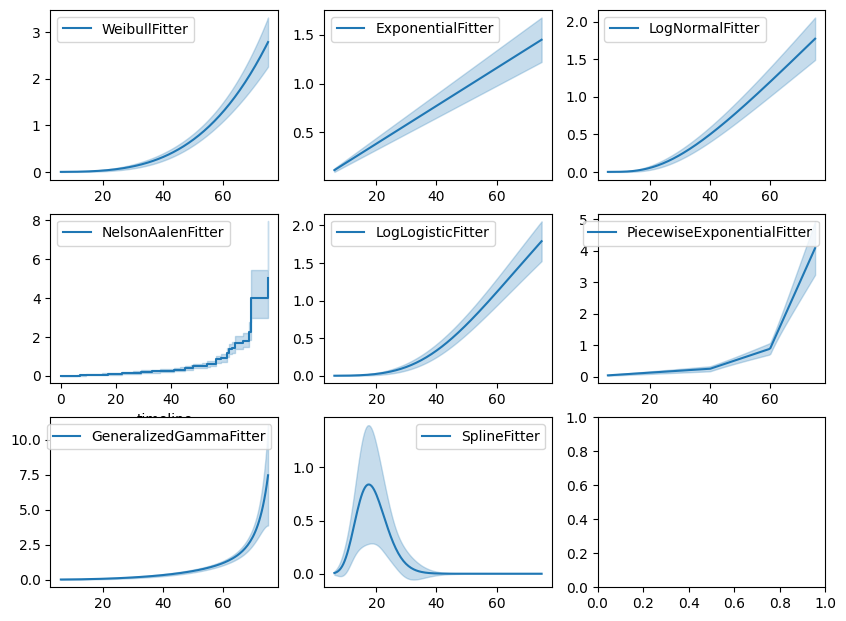

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
wbf.plot_cumulative_hazard(ax=axes[0][0])

exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
exf.plot_cumulative_hazard(ax=axes[0][1]) 

lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter') 
lnf.plot_cumulative_hazard(ax=axes[0][2])

naf = NelsonAalenFitter().fit(T, E, label='NelsonAalenFitter')
naf.plot_cumulative_hazard(ax=axes[1][0])

llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter') 
llf.plot_cumulative_hazard(ax=axes[1][1])

pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')  # Two changepoints at 40 and 60 
pwf.plot_cumulative_hazard(ax=axes[1][2])

ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
ggf.plot_cumulative_hazard(ax=axes[2][0]) 

spf = SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter')  # Four knots
spf.plot_cumulative_hazard(ax=axes[2][1])  

### Parametric models for survival analysis 